In [40]:
import os
import numpy as np 
import matplotlib.pyplot as plt 
%matplotlib inline

#External library pillow is an image library 
#that has pgm support
from PIL import Image

#Read in images and format into matrix of size 10304x400


#allocate image array to desired output size of 10304x400
img_arr = np.zeros([10304, 400])

#initialize iterator 
k = 0

#loop through number of participants (folders) 1-40
for i in range(1, len(os.listdir('att_faces'))):
    #loop through individual images per participant 1-10
    for j in range(1, len(os.listdir('att_faces/s'+str(i)))+1):
        
        #save images to variable 
        images = 'att_faces/s'+str(i)+'/'+str(j)+'.pgm'
        
        #load image into PIL imager 
        img = Image.open(images)
        
        #assigned temp image to temporary numpy array 
        temp = np.array(img)
        
        #reshapre image to desired output size 10304x400
        img_arr[:,k] = np.reshape(temp, (temp.shape[0] * temp.shape[1]))
        
        #update iterator 
        k += 1

In [41]:
#convert image matrix img_arr to float 
img_arr.astype(float)

array([[ 48.,  60.,  39., ..., 125., 119., 125.],
       [ 49.,  60.,  44., ..., 119., 120., 124.],
       [ 45.,  62.,  53., ..., 124., 120., 124.],
       ...,
       [ 47.,  32.,  29., ...,  36.,  89.,  36.],
       [ 46.,  34.,  26., ...,  39.,  94.,  35.],
       [ 46.,  34.,  29., ...,  40.,  85.,  34.]])

In [42]:
#Split datasets

# create arrays of size 10304xnum of cols for each set 
test_set = np.zeros([10304,80])
train_set = np.zeros([10304,160])
gallery_set = np.zeros([10304,160])

#set counter 
k = 0

#loop len(num of cols) - 10 with step size of 10
#each 10 columns represent a different image of an individual
for j in range(0,391,10):
    #save first and second image for each person in the test set 
    test_set[:,k] = img_arr[:,j]
    #update counter each time 
    k += 1
    test_set[:,k] = img_arr[:,j+1] 
    k += 1 

#set counter    
k = 0

#loop len(num of cols) - 10 with step size of 10
#each 10 columns represent a different image of an individual
for j in range(0, 391,10):
    #save third to sixth image per person in training set 
    train_set[:,k] = img_arr[:,j+2]
    #update counter each time 
    k += 1 
    train_set[:,k] = img_arr[:,j+3]
    k += 1 
    train_set[:,k] = img_arr[:,j+4]
    k += 1 
    train_set[:,k] = img_arr[:,j+5]
    k += 1

#set counter
k = 0

#loop len(num of cols) - 10 with step size of 10
#each 10 columns represent a different image of an individual
for j in range(0, 391, 10):
    #save seventh to 10th image per person in gallery set
    gallery_set[:,k] = img_arr[:,j+6]
    #update counter each time 
    k += 1
    gallery_set[:,k] = img_arr[:,j+7]
    k += 1
    gallery_set[:,k] = img_arr[:,j+8]
    k += 1
    gallery_set[:,k] = img_arr[:,j+9]
    k += 1

(10304, 80)


In [43]:
#Calculate the mean of each row in the test_set
#axis 0 calculates mean through rows 
test_means = np.mean(test_set, axis=0)
train_means = np.mean(train_set, axis=0)
gallery_means = np.mean(gallery_set, axis=0)

In [44]:
#center the data by subtracting the mean of each row 
#with the original data set
test_set_centered = np.subtract(test_set, test_means)
train_set_centered = np.subtract(train_set, train_means)
gallery_set_centered = np.subtract(gallery_set, gallery_means)

In [48]:
#find the mean of the original image matrix to find the average face of the entire dataset
average_face = np.mean(img_arr, axis=1)
#reshape the average_face_output to 112x92 and convert matrix to int 
average_face_output = np.reshape(average_face, (112,92)).astype(int)

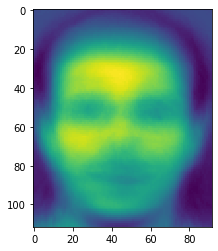

In [50]:
#show plot of average face
plt.imshow(average_face_output)

In [70]:
"""
compute the covariance matrix of the data. 
The covariance matrix tells us how much each of the 
columns of the data vary with respect to each other.
The diagonal of the covariance matrix is called the "variance"
as it tells us how much the data within each column of the data
matrix varies.
"""

centered_train_trans = train_set_centered.transpose()
centered_train_trans.shape

(160, 10304)

In [91]:
train_set_centered.shape

(10304, 160)